In [174]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import seaborn as sns
from itertools import chain
import shapely.vectorized as sv

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

## BIAS CORRECTION USING MEVD MAPS

In [186]:
# product, time_reso, ncolor = 'IMERG', '1dy', 0
# product, time_reso, ncolor = 'CMORPH', '3h', 1
# product, time_reso, ncolor = 'MSWEP', '3h', 2
# product, time_reso, ncolor = 'ERA5', '3h', 3
# product, time_reso, ncolor = 'GSMaP', '3h', 4
# product, time_reso, ncolor = 'CHIRPS', '1dy', 5
product, time_reso, ncolor = 'ENSEMBLE_median', '1dy', 6

In [176]:
frac = 0.7
seed = 7

In [177]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson')) 
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [ ]:
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
dir_font = os.path.join('/')
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')

In [179]:
italy_geom = ITALY.union_all()

In [180]:
def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    OBS, MEVd = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Obs_ = data[keys_QUANTILES[nn]].OBS.values[3]
            Down_ = data[keys_QUANTILES[nn]].SAT_down.values[3] 

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(Obs_)
            MEVd.append(Down_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'MEVd':MEVd})

    return DF_DATA

def Log_linear_test_ALL(OBS, SAT, SAT_ALL):
    obs_log = np.log1p(OBS)
    sat_log = np.log1p(SAT)

    mask = (~np.isnan(obs_log)) & (~np.isnan(sat_log))

    obs_log_clean = obs_log[mask]
    sat_log_clean = sat_log[mask]

    model = LinearRegression()
    model.fit(sat_log_clean.reshape(-1, 1), obs_log_clean)

    SAT_ALL_log = np.log1p(SAT_ALL.flatten())
    SAT_ALL_log_clear = SAT_ALL_log[~np.isnan(SAT_ALL_log)]

    sat_corr_log = model.predict(SAT_ALL_log_clear.reshape(-1, 1))
    sat_corrected = np.expm1(sat_corr_log)
    
    return sat_corrected

def CDFt(obs, sat_hist, sat_all):

    # --- Remove NaNs consistently (calibration only)
    mask = (~np.isnan(obs)) & (~np.isnan(sat_hist))
    obs = obs[mask]
    sat_hist = sat_hist[mask]

    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat_hist)

    n = len(sat_sorted)
    p = (np.arange(1, n + 1) - 0.5) / n

    # --- Flatten sat_all
    sat_all_flat = sat_all.flatten()
    sat_corr_flat = np.full_like(sat_all_flat, np.nan, dtype=float)

    for i, x in enumerate(sat_all_flat):

        if np.isnan(x):
            continue

        q = np.interp(x, sat_sorted, p, left=p[0], right=p[-1])
        sat_corr_flat[i] = np.interp(q, p, obs_sorted)

    sat_corr_flat = np.maximum(sat_corr_flat, 0.0)

    # --- Reshape back
    sat_corr = sat_corr_flat.reshape(sat_all.shape)

    return sat_corr

def linear_regression(OBS, DOWN):
    
    OBS = np.array(OBS)
    DOWN = np.array(DOWN)

    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)
    
    return slope, intercept, x_line, y_line

In [182]:
dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
DF_INPUT = get_parameters('ENSEMBLE_ALL_MEDIAN',dir_)
# DF_INPUT = get_parameters(product,dir_)

In [183]:
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

Q_train_list = []
Q_val_list = []

for iso in METADATA_CLEAR['ISO'].unique():

    META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_train_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_train_list.append(META_80)
    Q_val_list.append(META_20)

Q_train = pd.concat(Q_train_list, ignore_index=True)
Q_val = pd.concat(Q_val_list, ignore_index=True)
list_train = Q_train.File.values

In [184]:
DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

In [191]:
pos = 3

if product == 'ENSEMBLE_median':
    print('Ensemble')
    down_base = os.path.join(sat_base,'5_ENSEMBLE')
    filename = f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc'
else:
    down_base = os.path.join(sat_base,'5_DOWN')
    filename = f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'

dir_in = os.path.join(down_base, filename)

DATA = xr.open_dataset(dir_in)
Tr = int(DATA.Tr[pos].values)
print(f'Return period: {Tr} years')

lons, lats = DATA.lon.data, DATA.lat.data
lon2dIM, lat2dIM = np.meshgrid(DATA.lon.data, DATA.lat.data)

MEVd_IM = DATA.Mev_d

mask_italy = sv.contains(italy_geom, lon2dIM, lat2dIM)
MEVd_IM = MEVd_IM.where(mask_italy)
MEVd_IM = MEVd_IM[pos,:,:].values

Ensemble
Return period: 50 years


In [192]:
original_shape = MEVd_IM.shape
mask = ~np.isnan(MEVd_IM)
MEVd_IM_LLc_full = Log_linear_test_ALL(DF_train.OBS.values, DF_train.MEVd.values,MEVd_IM)
MEVd_IM_LLc_2d = np.full(original_shape, np.nan)
MEVd_IM_LLc_2d[mask] = MEVd_IM_LLc_full

In [193]:
MEVd_IM_QQc_2d = CDFt(DF_train.OBS.values, DF_train.MEVd.values,MEVd_IM)

In [ ]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "MEVd_LLc": (("lat","lon"), MEVd_IM_LLc_2d),
        "MEVd_QQc": (("lat","lon"), MEVd_IM_QQc_2d),
        },
    coords={
        'lat': lats, 
        'lon': lons
        },
        attrs=dict(description=f"{product} Extreme quantiles corrected for {Tr} years, applying QQc and LLc method using 70% of stations in Italy",))

DOWN_corrected.MEVd_LLc.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_LLc.attrs["long_name"] = "Extreme quantiles corrected with LLc method"
DOWN_corrected.MEVd_LLc.attrs["origname"] = "Linear Regresion log"

DOWN_corrected.MEVd_QQc.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_QQc.attrs["long_name"] = "Extreme quantiles corrected with QQc method"
DOWN_corrected.MEVd_QQc.attrs["origname"] = "Quantile-Quantile map"

dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','QUANTILE')
PRE_out = os.path.join(os.path.join(dir_base, dir_in.split('/')[-1].replace('_pearson',f'_pearson_QQc_LLc_{str(seed).zfill(4)}')))
print(f'Exportin as: {PRE_out}')
# DOWN_corrected.to_netcdf(PRE_out)

Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0007_median.nc


## Validation

In [197]:
DF_val = DF_INPUT[DF_INPUT['STATION'].isin(Q_val['File'])].reset_index(drop=True)
lats_obs = DF_val['LAT'].values
lons_obs = DF_val['LON'].values

In [198]:
MEV_QQc_vals, MEV_LLc_vals = [], []

for lat, lon in zip(DF_val['LAT'].values, DF_val['LON'].values):
    ilat = np.argmin(np.abs(lats - lat))
    ilon = np.argmin(np.abs(lons - lon))
    MEV_LLc_vals.append(MEVd_IM_LLc_2d[ilat, ilon])
    MEV_QQc_vals.append(MEVd_IM_QQc_2d[ilat, ilon])

MEV_LLc_vals = np.array(MEV_LLc_vals)
MEV_QQc_vals = np.array(MEV_QQc_vals)


DF_val['MEVd_LLc'] = MEV_LLc_vals
DF_val['MEVd_QQc'] = MEV_QQc_vals

In [199]:
RE = (DF_val.MEVd.values - DF_val.OBS.values)/DF_val.OBS.values
RE_LLc = (DF_val.MEVd_LLc.values - DF_val.OBS.values)/DF_val.OBS.values
RE_QQc = (DF_val.MEVd_QQc.values - DF_val.OBS.values)/DF_val.OBS.values

In [200]:
DF_val['RE'] = RE
DF_val['RE_LLc'] = RE_LLc
DF_val['RE_QQc'] = RE_QQc

In [201]:
DF_val.head(3)

,STATION,LON,LAT,ELEV,OBS,MEVd,MEVd_LLc,MEVd_QQc,RE,RE_LLc,RE_QQc
0,IT-880_35807_FTS_1440_QCv4.csv,8.965278,39.157227,159.336197,181.723288,80.820457,110.327574,95.444926,-0.555255,-0.392881,-0.474779
1,IT-880_35540_FTS_1440_QCv4.csv,9.411671,40.109446,1209.157959,219.866846,120.080193,168.804666,171.011000,-0.453850,-0.232241,-0.222207
2,IT-880_35515_FTS_1440_QCv4.csv,9.513059,39.795554,573.283875,211.849633,102.278249,146.314415,142.180422,-0.517213,-0.309348,-0.328862


In [202]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

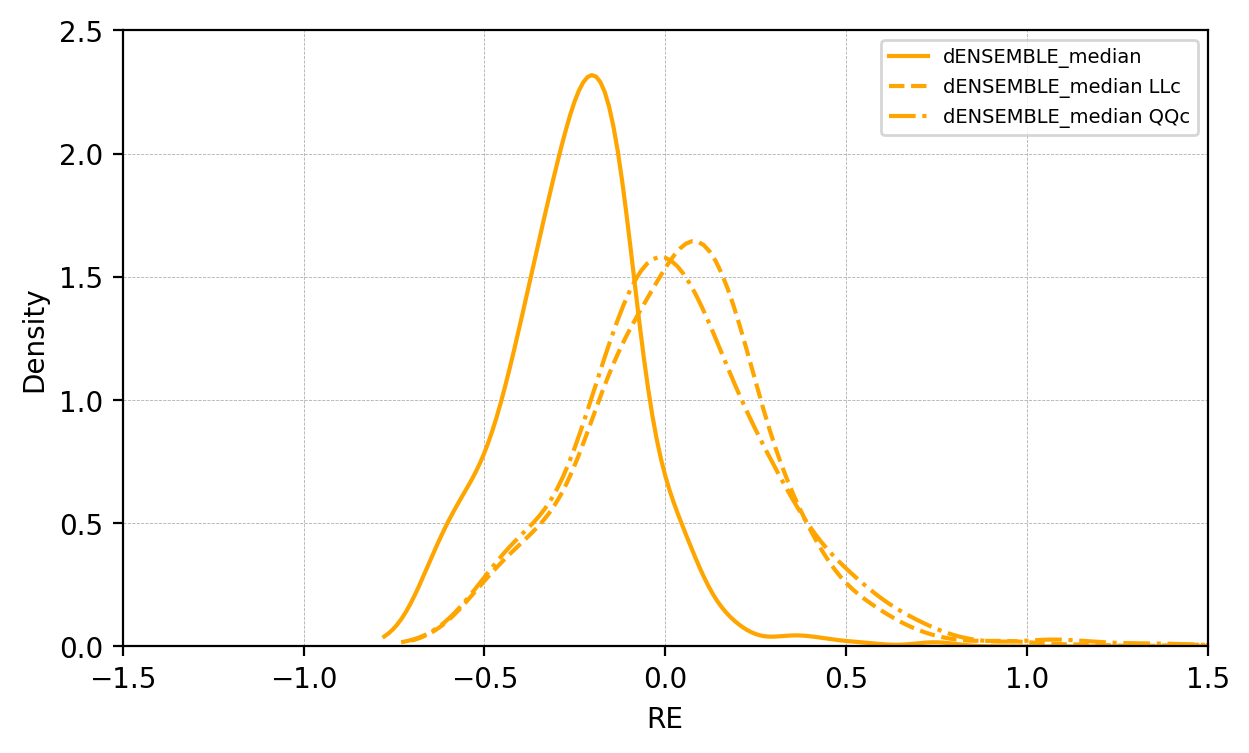

In [203]:
fig = plt.figure(figsize=(7,4),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_val.RE,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product}',
            clip=(np.nanmin(np.array(DF_val.RE)), np.nanmax(np.array(DF_val.RE))))
sns.kdeplot(DF_val.RE_LLc,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} LLc',linestyle='--',
            clip=(np.nanmin(np.array(DF_val.RE_LLc)), np.nanmax(np.array(DF_val.RE_LLc))))
sns.kdeplot(DF_val.RE_QQc,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} QQc',linestyle='-.',
            clip=(np.nanmin(np.array(DF_val.RE_QQc)), np.nanmax(np.array(DF_val.RE_QQc))))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [204]:
_, _, x_OBS, y_OBS = linear_regression(DF_val.OBS, DF_val.MEVd)
_, _, x_LLc, y_LLc = linear_regression(DF_val.OBS, DF_val.MEVd_LLc)
_, _, x_QQc, y_QQc = linear_regression(DF_val.OBS, DF_val.MEVd_QQc)

Text(0.0, 1.0, '(c) dENSEMBLE_median Extreme Quantile - QQc')

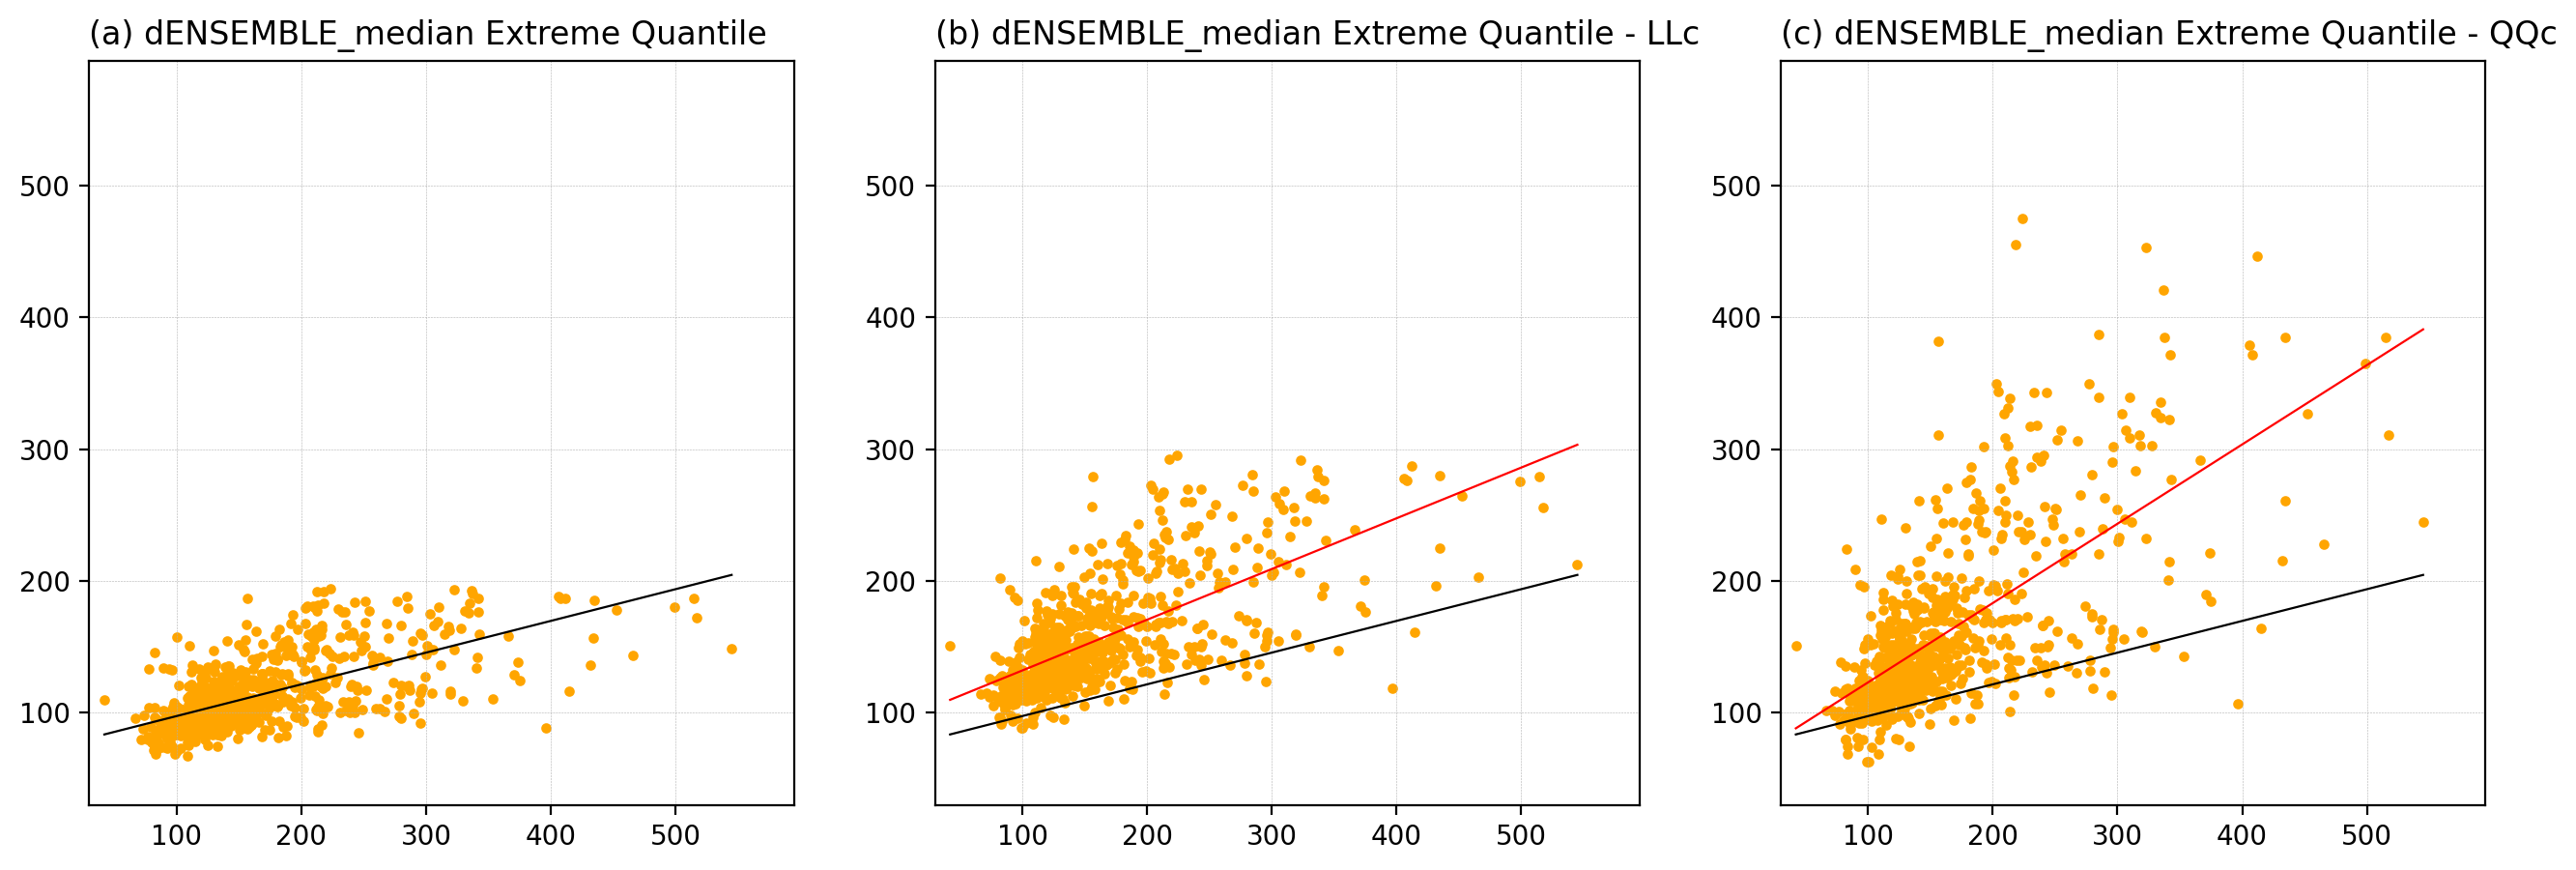

In [205]:
vmin = DF_val.OBS.min()
vmax = DF_val.OBS.max()

fig = plt.figure(figsize=(16,5),dpi=200)
gs = gridspec.GridSpec(1,3)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.scatter(DF_val.OBS, DF_val.MEVd, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(a) d{product} Extreme Quantile ', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(DF_val.OBS, DF_val.MEVd_LLc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(x_LLc, y_LLc, c='r',linewidth=0.8)
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(b) d{product} Extreme Quantile - LLc', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 2])

ax1.scatter(DF_val.OBS, DF_val.MEVd_QQc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(x_QQc, y_QQc, c='r',linewidth=0.8)
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(c) d{product} Extreme Quantile - QQc', fontsize=12, loc='left')